In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from tqdm import tqdm
from aa import AndersonAcceleration

# Gradient descent vs. Anderson-accelerated GD

Let's optimize another objective. In this case we're training a logistic regression model with $\ell_2$ regularization. Let $A \in \mathbb{R}^{n \times d}$ be the design matrix for $n$ examples each with $d$ dimensions, and let $b \in \{-1, 1\}^n$ be the response variables. Given a vector $x \in \mathbb{R}^d$ of weights, the optimization problem for $\ell_2$-regularized logistic regression is
\begin{align*}
\min_{x \in \mathbb{R}^d} \left\{ f(x) := \sum_{i=1}^{n} \log \left( 1 + \exp(-b_i A_i x) \right) + \frac{\lambda}{2} ||x||_2^2 \right\},
\end{align*}
where $\lambda \geq 0$, $b_i$ and $A_i$ are the $i$th element of $b$ and $i$th row of $A$, respectively. Note that $A_i$ is a row vector.

The gradient and Hessian of $f$, respectively, are:
\begin{align*}
\nabla f(x) &= - \sum_{i=1}^{n} \frac{z_i}{1 + z_i} b_i A_i^T  + \lambda x, \\
\nabla^2 f(x) &= A^\top \mathrm{diag}\left(\frac{\exp(z_1)}{(1 + \exp(z_1))^2}, \ldots, \frac{\exp(z_n)}{(1 + \exp(z_n))^2} \right) A + \lambda I,
\end{align*}

where $z_i := \exp(- b_i A_i x)$, and $I$ is the $d \times d$ identity matrix.

It can be seen that the $f$ is a continuous, $L$-smooth and $\mu$-strongly convex function with $\mu \geq \lambda$ and $L \leq \frac{1}{4} ||A||_2^2 + \lambda$. Therefore, GD will guarantee linear convergence: with condition number $\kappa := \frac{L}{\mu}$, we need $O\left( \kappa \log \frac{1}{\epsilon} \right)$ to achieve $f(x) - f(x^*) \leq \epsilon$.

There is no theoretical guarantee (as far as I'm aware) that AA achieves $O\left( \sqrt{\kappa} \log \frac{1}{\epsilon} \right)$ convergence rate on non-quadratic objective like in this logistic regression scenario. However, the below strongly suggests that it is the case; at the very least, AA converges much faster than GD.

Let's set the condition number $\kappa$ to $10^6$ and compare the two algorithms. First, define our logistic regression class.

In [2]:
class LogReg():
    def __init__(self, A, b, lamb, x0=None):
        self.A = A                  # Design matrix
        self.n, self.dim = A.shape
        self.b = b                  # Responses (target variables1)
        self.lamb = lamb            # l2 regularization      
        self.x = x0 if x0 is not None else np.zeros(self.dim)
    def loss(self, x=None):
        if x is None:
            x = self.x
        f = -self.b * np.dot(self.A, x)
        f = 1 + np.exp(f)
        f = np.log(f)
        f = np.sum(f)
        f += (self.lamb / 2) * np.sum(x ** 2)
        return f
    def grad(self, x=None):
        if x is None:
            x = self.x
        z = -self.b * np.dot(self.A, x)
        exp_z = np.exp(z)
        grad = -self.b * (self.A.T * (exp_z / (1 + exp_z)))
        grad = np.sum(grad.T, 0)
        grad += self.lamb * x
        return grad
    def hess(self, x=None):
        if x is None:
            x = self.x
        z = -self.b * np.dot(self.A, x)
        exp_z = np.exp(z)
        diag = exp_z / ((1 + exp_z) ** 2)
        self.diag = diag
        hess = self.A.T @ np.diag(diag) @ self.A
        hess += self.lamb * np.eye(self.dim)
        return hess

We will be using the Madelon dataset from the [LIBSVM library](https://www.csie.ntu.edu.tw/~cjlin/libsvm/). We're only using the training set, which contains $n = 2,000$ examples in $d=500$ dimensions.

The below code will download the dataset, save it to the `./madelon` file and load it to $A$ and $b$.

In [3]:
%%bash
# Download the dataset
if [ -f ./madelon ]; then
    echo "Dataset already exists."
else
    echo "Dataset doesn't exist. Downloading"
    curl https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/madelon > madelon
fi

Dataset already exists.


In [4]:
# Load the dataset to A and b
from joblib import Memory
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix
A, b = load_svmlight_file("madelon")
A = csr_matrix.toarray(A)

In [5]:
# Now set up lambda to have a desired condition number
# Normalize A and ensure every row has unit length
A -= np.mean(A, 0)
A /= LA.norm(A, axis=1).reshape(-1, 1)

kappa = 1e6
mu = (1/4) * LA.norm(A, 2) ** 2 / (kappa - 1)
L = (1/4) * LA.norm(A, 2) ** 2 + mu

# Double-check
kappa = L / mu
print("L     =", L)
print("mu    =", mu)
print("kappa =", kappa)

L     = 47.86540309753588
mu    = 4.7865403097535884e-05
kappa = 1000000.0


In [6]:
# Step size/learning rate
eta = 1 / L

logreg = LogReg(A=A, b=b, lamb=mu)

f_star = np.inf

def opt(x0=None, num_iters=10000, acc=None):
    if x0 is None:
        x0 = np.random.rand(A.shape[1])
    
    # History of all f(x_t)
    x_prev = x0
    f_hist = [logreg.loss(x_prev)]
    for t in tqdm(range(num_iters)):
        x_new = x_prev - eta * logreg.grad(x_prev)
        if acc is not None:
            x_new = acc.apply(x_new)
        f_hist.append(logreg.loss(x_new))
        
        # Stop when the gradient vanishes
        if LA.norm(logreg.grad(x_new)) < 1e-7:
            break

        x_prev = x_new
    return f_hist

In [7]:
np.random.seed(100)
x0 = np.random.rand(A.shape[1])
f_hist_gd = opt(x0=x0, num_iters=10000)
f_hist_aa = opt(x0=x0, num_iters=10000, 
                acc=AndersonAcceleration(window_size=2, 
                                         reg=0))
f_hist_aa_5 = opt(x0=x0, num_iters=10000, 
                acc=AndersonAcceleration(window_size=5, 
                                         reg=0))

100%|████████████████████████████████████████████████████████| 10000/10000 [01:34<00:00, 106.24it/s]


In [8]:
# f* can't be found analytically, so we just we it as the smallest
# f we can find
f_star = np.min(np.concatenate((f_hist_gd, f_hist_aa, f_hist_aa_5)))

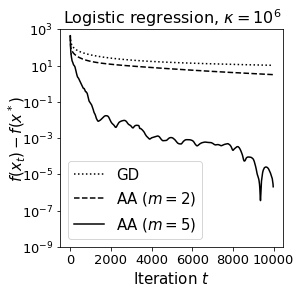

In [9]:
plt.figure(figsize=(4, 4))
plt.plot(np.array(f_hist_gd)[:-20] - f_star, label="GD", 
         linestyle=":", c="k")
plt.plot(np.array(f_hist_aa)[:-20] - f_star, label="AA ($m = 2$)", 
         linestyle="--", c="k")
plt.plot(np.array(f_hist_aa_5)[:-20] - f_star, label="AA ($m = 5$)", 
         linestyle="-", c="k")
plt.legend(loc="best", prop={'size': 15})
plt.ylim([1e-9, 1e3])
plt.yscale("log")
plt.yticks(size=13)
plt.xticks(size=13)
plt.ylabel("$f(x_t) - f(x^*)$", size=15, va="center", ha="center")
plt.xlabel("Iteration $t$", size=15, ha="center")
plt.title("Logistic regression, $\kappa = 10^{6}$", size=16)
plt.savefig("AA_GD_logistic_regression.png", bbox_inches="tight", dpi=100)
plt.show()